In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
usersdf = pd.read_csv('takehome_users.csv')
engagementdf = pd.read_csv('takehome_user_engagement.csv')

## Engagement

In [35]:
engagementdf.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [36]:
#convert to datetime
engagementdf['time_stamp'] = pd.to_datetime(
    engagementdf['time_stamp'], format='%Y-%m-%d %H:%M:%S'
)

In [37]:
#define adopted user
def adoptedrequirement(df, days=7, logins=3):
    from datetime import timedelta
    df['date'] = df['time_stamp'].dt.date
    df = df.drop_duplicates(subset='date').sort_values('date')
    passed_days = df['date'].diff(periods=logins-1)
    return any(passed_days <= timedelta(days=days))
adopted = engagementdf.groupby('user_id').apply(adoptedrequirement)
adopted.name = 'adopted_user'

## Users

In [39]:
#add engagement as new column 
usersdf = usersdf.set_index('object_id')
usersdf.index.name = 'user_id'
usersdf = pd.merge(adopted, usersdf, how="left", on="user_id")

In [40]:
usersdf['adopted_user'] = (usersdf['adopted_user']).astype(int)
usersdf.head()

,adopted_user,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
user_id,,,,,,,,,,
1,0,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
2,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
3,0,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
4,0,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
5,0,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [41]:
usersdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 1 to 12000
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   adopted_user                8823 non-null   int64  
 1   creation_time               8823 non-null   object 
 2   name                        8823 non-null   object 
 3   email                       8823 non-null   object 
 4   creation_source             8823 non-null   object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    8823 non-null   int64  
 7   enabled_for_marketing_drip  8823 non-null   int64  
 8   org_id                      8823 non-null   int64  
 9   invited_by_user_id          4776 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 758.2+ KB


In [42]:
#Convert to datetime
usersdf['creation_time'] = pd.to_datetime(
    usersdf['creation_time'], format='%Y-%m-%d %H:%M:%S')
usersdf['last_session_creation_time'] = pd.to_datetime(
    usersdf['last_session_creation_time'], unit='s')

I'm going to remove the time-based features for my predictive dataset because I'm more interested in investigating the non-time based features. We can already understand intuitively that a frequent user, or a recent user, is more likely to be an adopted one.

In [51]:
#Remove features
usersdf = usersdf.drop(['org_id', 'invited_by_user_id', 'name', 'email', 'creation_time', 'last_session_creation_time'], axis=1)

Next I'm going to convert the creation_source column into 5 dummy variables

In [53]:
source = pd.get_dummies(usersdf['creation_source'])

In [54]:
df = pd.concat([usersdf, source], axis=1)
df = df.drop(['creation_source'], axis=1)

In [55]:
df.head()

,adopted_user,opted_in_to_mailing_list,enabled_for_marketing_drip,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
user_id,,,,,,,,
1,0,1,0,1,0,0,0,0
2,1,0,0,0,1,0,0,0
3,0,0,0,0,1,0,0,0
4,0,0,0,1,0,0,0,0
5,0,0,0,1,0,0,0,0


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 1 to 12000
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   adopted_user                8823 non-null   int64
 1   opted_in_to_mailing_list    8823 non-null   int64
 2   enabled_for_marketing_drip  8823 non-null   int64
 3   GUEST_INVITE                8823 non-null   uint8
 4   ORG_INVITE                  8823 non-null   uint8
 5   PERSONAL_PROJECTS           8823 non-null   uint8
 6   SIGNUP                      8823 non-null   uint8
 7   SIGNUP_GOOGLE_AUTH          8823 non-null   uint8
dtypes: int64(3), uint8(5)
memory usage: 318.8 KB


## Heatmap

<AxesSubplot:>

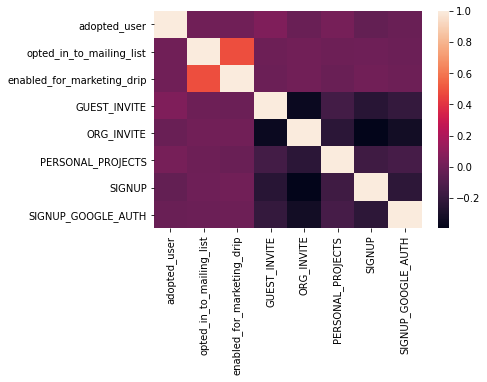

In [57]:
sns.heatmap(df.corr())

## Modeling

In [61]:
y = df['adopted_user']
X = df.drop('adopted_user', axis=1)

In [62]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y)

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
clf = RandomForestClassifier(random_state=42, class_weight='balanced')
params = {'n_estimators': [10, 50, 100, 200]}
model = GridSearchCV(clf, params)
model.fit(Xtrain, ytrain)
print('Best parameters were', model.best_params_)
print('Best average precision was', model.best_score_)

Best parameters were {'n_estimators': 100}
Best average precision was 0.6657106548561015


In [65]:
from sklearn.metrics import classification_report, accuracy_score
model = RandomForestClassifier(
    random_state=42, class_weight='balanced', n_estimators=100
)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
print('Accuracy', accuracy_score(ytest, ypred))
print(classification_report(ytest, ypred))

Accuracy 0.6749773345421578
              precision    recall  f1-score   support

           0       0.83      0.76      0.79      1790
           1       0.23      0.32      0.27       416

    accuracy                           0.67      2206
   macro avg       0.53      0.54      0.53      2206
weighted avg       0.72      0.67      0.69      2206



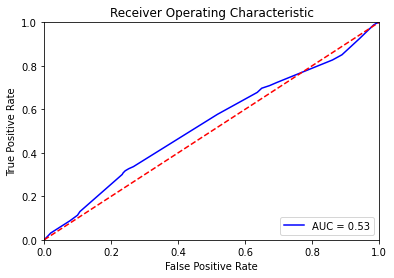

In [68]:
import sklearn.metrics as metrics
probs = model.predict_proba(Xtest)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(ytest, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [71]:
imp = pd.Series(model.feature_importances_, index=X.columns)
imp = imp.sort_values(ascending=False)
print(imp)

GUEST_INVITE                  0.263613
PERSONAL_PROJECTS             0.165029
opted_in_to_mailing_list      0.160678
enabled_for_marketing_drip    0.142874
ORG_INVITE                    0.111985
SIGNUP                        0.090541
SIGNUP_GOOGLE_AUTH            0.065279
dtype: float64


GUEST_INVITE was the most important factor when it comes to predicting user adoption